In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from ecco_pipeline.baseclasses import Grid
from ecco_pipeline.conf.global_settings import OUTPUT_DIR
from ecco_pipeline.utils.pipeline_utils.file_utils import get_date
from ecco_pipeline.transformations.grid_transformation import Transformation
from ecco_pipeline.utils.processing_utils.ds_functions import PreprocessingFuncs

In [2]:
ds_name = "G02202_V5"
hemisphere = 'north'
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')

if config.get("hemi_pattern"):
    ds_granules = [g for g in ds_granules if config["hemi_pattern"][hemisphere] in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/G02202_V5/harvested_granules/2024/sic_psn25_20241103_F17_v05r00.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:                               (time: 1, y: 448, x: 304)
Coordinates:
  * x                                     (x) float64 -3.838e+06 ... 3.738e+06
  * y                                     (y) float64 5.838e+06 ... -5.338e+06
  * time                                  (time) datetime64[ns] 2024-11-03
Data variables:
    crs                                   int32 ...
    cdr_seaice_conc_interp_spatial_flag   (time, y, x) uint8 ...
    cdr_seaice_conc_qa_flag               (time, y, x) uint8 ...
    cdr_seaice_conc_interp_temporal_flag  (time, y, x) uint8 ...
    cdr_seaice_conc                       (time, y, x) float32 ...
    cdr_seaice_conc_stdev                 (time, y, x) float32 ...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2025-03-25T16:45:35Z
    time_coverage_start:       2024-11-03T00:00:00Z
    time_coverage_end:         2024-11-03T23:59:59Z
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    ...                        ...
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

# Load grid

In [5]:
grids = glob('grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/TPOSE.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
target_grid = Grid(grid_ds)
target_grid.ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

In [8]:
ds = PreprocessingFuncs().nsidc_seaice_nt_extraction(sample_granule_path, T.fields)
ds

<xarray.Dataset>
Dimensions:                               (time: 1, y: 448, x: 304)
Coordinates:
  * x                                     (x) float64 -3.838e+06 ... 3.738e+06
  * y                                     (y) float64 5.838e+06 ... -5.338e+06
  * time                                  (time) datetime64[ns] 2024-11-03
Data variables:
    crs                                   int32 ...
    cdr_seaice_conc_interp_spatial_flag   (time, y, x) uint8 ...
    cdr_seaice_conc_qa_flag               (time, y, x) uint8 ...
    cdr_seaice_conc_interp_temporal_flag  (time, y, x) uint8 ...
    cdr_seaice_conc                       (time, y, x) float32 ...
    cdr_seaice_conc_stdev                 (time, y, x) float32 ...
    raw_nt_seaice_conc                    (time, y, x) float32 ...
Attributes: (12/46)
    Conventions:               CF-1.11, ACDD-1.3
    date_created:              2025-03-25T16:45:35Z
    time_coverage_start:       2024-11-03T00:00:00Z
    time_coverage_end:         2024-11-03T23:59:59Z
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    ...                        ...
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

# Make mapping factors

In [9]:
factors = T.make_factors(target_grid)

# Transformation

In [10]:
field_ds_list = T.transform(target_grid, factors, ds)

In [11]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                                     (time: 1, tile: 13, j: 90,
                                                 i: 90, nv: 2)
Coordinates:
  * time                                        (time) datetime64[ns] 2024-11...
  * tile                                        (tile) int16 0 1 2 ... 10 11 12
  * j                                           (j) int16 0 1 2 3 ... 87 88 89
  * i                                           (i) int16 0 1 2 3 ... 87 88 89
    XC                                          (tile, j, i) float32 -111.6 ....
    YC                                          (tile, j, i) float32 -88.24 ....
    time_bnds                                   (time, nv) datetime64[ns] 202...
Dimensions without coordinates: nv
Data variables:
    cdr_seaice_conc_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9....
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       NOAA/NSIDC Climate Data Record of Passive M...
    original_dataset_short_name:  G02202_V5
    original_dataset_url:         https://nsidc.org/data/G02202/versions/5
    original_dataset_reference:   https://nsidc.org/sites/nsidc.org/files/tec...
    original_dataset_doi:         10.7265/efmz-2t65
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.19
    notes:                        All values flagged as pole_hole, lakes, coa...

# Visualization

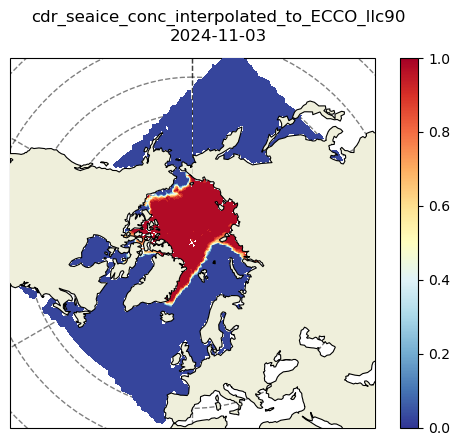

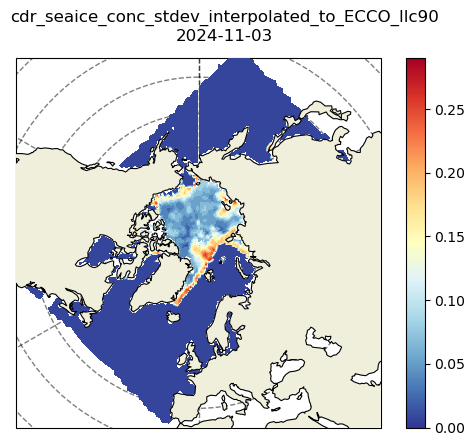

In [12]:
for field_ds in field_ds_list:
    plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], 'nh')
